In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sys
import pdb

In [3]:
sys.path.append('../..')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import pickle
from sklearn.model_selection import KFold
import glob
from utils import calc_loadings
from loaders import load_sabes, load_peanut
from decoders import lr_decoder, lr_encoder
from utils import apply_df_filters

In [6]:
sabes_decoding_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/sabes_decoding2/sabes_decoding2_*.dat')
sabes_kca_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/sabes_kca2/sabes_kca2_*.dat')
peanut_decoding_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/peanut_decoding2/peanut_decoding2_*.dat')
peanut_kca_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/peanut_kca2/peanut_kca2_*.dat')                            

In [7]:
results_list = []
for file in peanut_kca_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
peanut_kca_df = pd.DataFrame(results_list)

In [8]:
results_list = []
for file in sabes_kca_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
sabes_kca_df = pd.DataFrame(results_list)

### Sabes

In [96]:
data_path = '/media/akumar/Secondary/data/sabes'

In [97]:
data_files = sabes_kca_df["data_file"].unique()

In [98]:
sabes_kca_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'KCA', 'fit_all', 'PCA',
       'SFA', 'bin_width', 'filter_fn', 'filter_kwargs', 'boxcox',
       'spike_threshold', 'dim_vals', 'n_folds', 'T', 'ols_order',
       'data_file'],
      dtype='object')

In [99]:
decoder_params = {'trainlag': 4, 'testlag': 4, 'decoding_window': 3}
fold_idx = 0

result = {}
for data_file in tqdm(data_files):
    
    result[data_file] = {}
    
    KCA_df = apply_df_filters(sabes_kca_df, data_file=data_file, fold_idx=fold_idx)
    pca_df = apply_df_filters(sabes_kca_df, data_file=data_file, fit_all=True, fold_idx=fold_idx)
    
    dat = load_sabes('%s/%s' % (data_path, data_file), bin_width=KCA_df.iloc[0]["bin_width"],
                     filter_fn=KCA_df.iloc[0]['filter_fn'], filter_kwargs=KCA_df.iloc[0]['filter_kwargs'],
                     boxcox=KCA_df.iloc[0]['boxcox'], spike_threshold=KCA_df.iloc[0]['spike_threshold'])
    
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    kfold = KFold(n_splits=5, shuffle=False)
    train_idxs, test_idxs = next(kfold.split(X))
    ztrain = Z[train_idxs, :]
    ztest = Z[test_idxs, :]

    # Population level decoding/encoding - use the coefficient in the linear fit
    # Record both the weights in the coefficient but also the loadings onto the SVD

    xtrain = X[train_idxs, :]
    xtest = X[test_idxs, :]
    
    _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
    _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)

    result[data_file]['decoding_weights'] = decodingregressor.coef_
    result[data_file]['encoding_weights'] = encodingregressor.coef_
    
    u1, s1, vh1 = np.linalg.svd(decodingregressor.coef_[0:2, :], full_matrices=False)
    u2, s2, vh2 = np.linalg.svd(decodingregressor.coef_[2:4, :], full_matrices=False)
    u3, s3, vh3 = np.linalg.svd(decodingregressor.coef_[4:6, :], full_matrices=False)

    
    u4, s4, vh4 = np.linalg.svd(encodingregressor.coef_, full_matrices=False)
    
    result[data_file]['decoding_pos_svd'] = vh1
    result[data_file]['decoding_vel_svd'] = vh2
    result[data_file]['decoding_acc_svd'] = vh3

    result[data_file]['encoding_svd'] = u4
    
    r2_pos_decoding, r2_vel_decoding, r2_encoding = [], [], []
    
    decoding_weights = []
    encoding_weights = []
    
    decoding_weights_svd = []
    encoding_weights_svd = []
    
    
    for neu_idx in range(X.shape[1]):           #Fit all neurons one by one
        
        xtrain = X[train_idxs, neu_idx][:, np.newaxis]
        xtest = X[test_idxs, neu_idx][:, np.newaxis]
        # Decoding
        r2_pos, r2_vel, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_pos_decoding.append(r2_pos)
        r2_vel_decoding.append(r2_vel)
        
        decoding_weights.append(dr.coef_)
        
        # Encoding
        r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_encoding.append(r2_encoding_)
        encoding_weights.append(er.coef_)        
        
    result[data_file]['su_r2_pos_decoding'] = r2_pos_decoding
    result[data_file]['su_r2_vel_decoding'] = r2_vel_decoding
    result[data_file]['su_r2_encoding'] = r2_encoding
    result[data_file]['su_decoding_weight'] = decoding_weights
    result[data_file]['su_encoding_weight'] = encoding_weights        
    
    dim_vals = np.unique(KCA_df['dim'].values)
    KCA_loadings = np.zeros((dim_vals.size, X.shape[1]))
    pca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    
    for i, dim_ in enumerate(dim_vals):
        KCA_df_ = KCA_df.loc[KCA_df['dim'] == dim_]
        KCA_loadings[i, :] = calc_loadings(KCA_df_.iloc[0]['KCA']['coef'])
        pca_loadings[i, :] = calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:dim_])
    
    result[data_file]['kca_loadings'] = KCA_loadings
    result[data_file]['pca_loadings'] = pca_loadings

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [04:14<00:00,  9.08s/it]


In [100]:
dim_vals = np.arange(30)

In [101]:
# For each quantity, calculate the spearman r2 
kca_decoding_weightsr2 = np.zeros(dim_vals.size)
kca_decoding_svdr2 = np.zeros(dim_vals.size)
pca_decoding_weightsr2 = np.zeros(dim_vals.size)
pca_decoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_kca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_kca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[data_file]['decoding_weights'][2:4, :].T, 3))
        x2.extend(calc_loadings(result[data_file]['decoding_vel_svd'].T, 3))

    kca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_kca)[0]
    kca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_kca)[0]
    
    pca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

In [102]:
pca_decoding_weightsr2

array([0.3614911 , 0.42880271, 0.42630023, 0.42162091, 0.40789737,
       0.40236037, 0.3963059 , 0.39103937, 0.38622569, 0.3840631 ,
       0.38186928, 0.3794625 , 0.37813434, 0.37653339, 0.37458514,
       0.37284716, 0.37130482, 0.36918076, 0.36662584, 0.36423184,
       0.36213574, 0.3596151 , 0.35731322, 0.35532666, 0.3529454 ,
       0.34969866, 0.34754943, 0.34528133, 0.34351969, 0.34172005])

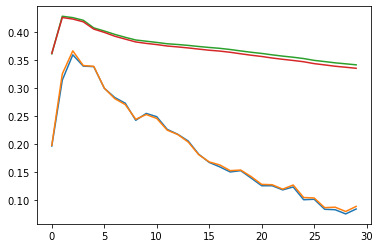

In [103]:
plt.plot(kca_decoding_weightsr2)
plt.plot(kca_decoding_svdr2)
plt.plot(pca_decoding_weightsr2)
plt.plot(pca_decoding_svdr2)

In [104]:
# For each quantity, calculate the spearman r2 
dca_encoding_weightsr2 = np.zeros(dim_vals.size)
dca_encoding_svdr2 = np.zeros(dim_vals.size)
pca_encoding_weightsr2 = np.zeros(dim_vals.size)
pca_encoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[data_file]['encoding_weights'], 1))
        x2.extend(calc_loadings(result[data_file]['encoding_svd'], 1))

    dca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

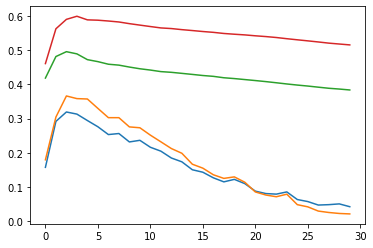

In [105]:
plt.plot(dca_encoding_weightsr2)
plt.plot(dca_encoding_svdr2)
plt.plot(pca_encoding_weightsr2)
plt.plot(pca_encoding_svdr2)

In [106]:
# For each quantity, calculate the spearman r2 
dca_suposweight_r2 = np.zeros(dim_vals.size)
dca_suvelweight_r2 = np.zeros(dim_vals.size)
pca_suposweight_r2 = np.zeros(dim_vals.size)
pca_suvelweight_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[data_file]['su_decoding_weight'][idx][0:2, :])
                   for idx in range(len(result[data_file]['su_decoding_weight']))])
        x2.extend([np.linalg.norm(result[data_file]['su_decoding_weight'][idx][2:4, :])
                   for idx in range(len(result[data_file]['su_decoding_weight']))])

    dca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_suvelweight_r2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_suvelweight_r2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

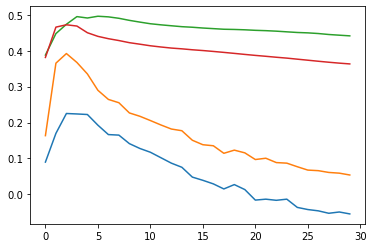

In [107]:
plt.plot(dca_suposweight_r2)
plt.plot(dca_suvelweight_r2)
plt.plot(pca_suposweight_r2)
plt.plot(pca_suvelweight_r2)

In [108]:
# For each quantity, calculate the spearman r2 
kca_suencoding_r2 = np.zeros(dim_vals.size)
pca_suencoding_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_kca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_kca.extend(result[data_file]['kca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[data_file]['su_r2_encoding'][idx])
                   for idx in range(len(result[data_file]['su_r2_encoding']))])

    kca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_kca)[0]
    pca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]

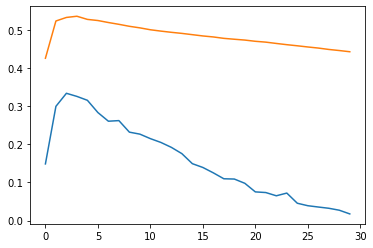

In [109]:
plt.plot(kca_suencoding_r2)
plt.plot(pca_suencoding_r2)

In [110]:
from tqdm import tqdm
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.kca import calc_mmse_from_cross_cov_mats
from dca.cov_util import calc_cross_cov_mats_from_data
from utils import apply_df_filters
import torch

In [145]:
with open('../v2/sabes_var_df.dat', 'rb') as f:
    var_df = pickle.load(f)

In [146]:
data_files = np.unique(var_df['data_file'].values)

In [113]:
datpath = '/media/akumar/Secondary/data/sabes'
mmse = {}
variance = {}
for i, data_file in tqdm(enumerate(data_files)):
    
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    dat = load_sabes('%s/%s' % (datpath, data_file), **df.iloc[0]['loader_args'])
    x = np.squeeze(dat['spike_rates'])
    
    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    # Stick to first fold of the data
    train_idxs, test_idxs = split_idxs[0]
    
    x = x[train_idxs]

    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    variance[data_file] = {}
    variance[data_file]['data'] = np.var(x, axis=0)
    variance[data_file]['model'] = np.diag(df.iloc[0]['W'])
    
    # Do NOT Normalize
    #x = StandardScaler().fit_transform(np.squeeze(dat['spike_rates']))
    cross_cov_mats = calc_cross_cov_mats_from_data(x, T=6)
    mmse[data_file] = {}
    mmse[data_file]['dataT1'] = []
    mmse[data_file]['dataT3'] = []
    mmse[data_file]['dataT5'] = []
    mmse[data_file]['modelT1'] = []
    mmse[data_file]['modelT3'] = []
    mmse[data_file]['modelT5'] = []

    cross_cov_mats = torch.tensor(cross_cov_mats)
    for j in range(A.shape[0]):

        C = np.zeros((1, A.shape[0]))
        C[0, j] = 1

        
        mmse[data_file]['dataT5'].append(calc_mmse_from_cross_cov_mats(cross_cov_mats, 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=False).detach().cpu().numpy())                
        mmse[data_file]['dataT3'].append(calc_mmse_from_cross_cov_mats(cross_cov_mats[0:4], 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=False).detach().cpu().numpy())                
        mmse[data_file]['dataT1'].append(calc_mmse_from_cross_cov_mats(cross_cov_mats[0:2], 
                                                                        torch.tensor(C.T),
                                                                        project_mmse=False).detach().cpu().numpy())                
    
        c, cf, cfp = ssr.mmse_cov(5, proj=C)
        mmse[data_file]['modelT5'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.mmse_cov(3, proj=C)
        mmse[data_file]['modelT3'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.mmse_cov(1, proj=C)
        mmse[data_file]['modelT1'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

28it [03:52,  8.29s/it]


In [114]:
# (empirical su variance)
x1 = []
# (model su variance)
x2 =[]
# (emprirical T1)
x3 = []
# (emprirical T3)
x4 = []
# (emprirical T5)
x5 = []
# (model T1)
x6 = []
# (model T3)
x7 = []
# (model T5)
x8 = []

# pca loadings
y1 = []
# kca loadings 
y2 = []

fold_idx = 0
for i, data_file in enumerate(data_files):

    KCA_df = apply_df_filters(sabes_kca_df, data_file=data_file, fold_idx=fold_idx, dim=2)
    pca_df = apply_df_filters(sabes_kca_df, data_file=data_file, fit_all=True, fold_idx=fold_idx)
    
    x1.extend(variance[data_file]['data'])
    x2.extend(variance[data_file]['model'])

    x3.extend(mmse[data_file]['dataT1'])
    x4.extend(mmse[data_file]['dataT3'])
    x5.extend(mmse[data_file]['dataT5'])
    
    x6.extend(mmse[data_file]['modelT1'])
    x7.extend(mmse[data_file]['modelT3'])
    x8.extend(mmse[data_file]['modelT5'])
    
    y1.extend(calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    y2.extend(calc_loadings(KCA_df.iloc[0]['KCA']['coef'])) 

    
r = np.zeros((8, 2))
for i, x_ in enumerate([x1, x2, x3, x4, x5, x6, x7, x8]):
    for j, y_ in enumerate([y1, y2]):
        r[i, j] = scipy.stats.spearmanr(x_, y_)[0]    

In [147]:
from dca_research.kca import KalmanComponentsAnalysis as KCA

In [148]:
from sklearn.decomposition import PCA

In [149]:
# Evaluate self consistency with model subspaces
reps = 10

spearmanr_kca = []

for i, data_file in tqdm(enumerate(data_files)):
    
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    dat = load_sabes('%s/%s' % (datpath, data_file), **df.iloc[0]['loader_args'])
    x = np.squeeze(dat['spike_rates'])
    
    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    # Stick to first fold of the data
    train_idxs, test_idxs = split_idxs[0]
    
    x = x[train_idxs]

    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    eig, U = np.linalg.eig(ssr.P)
    eigorder = np.argsort(eig)
    U = U[:, eigorder]
        
    # Data derived
    
    kcamodel = KCA(d=2, T=1, causal_weights=(1, 0), project_mmse=False)
    kcamodel.estimate_data_statistics(x)

    empirical_loadings = np.zeros((reps, A.shape[0]))
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        empirical_loadings[j, :] = calc_loadings(coef_)
    
    # Model derived
    model_loadings = np.zeros((reps, A.shape[0]))
    kcamodel = KCA(d=2, T=1, causal_weights=(1, 0), project_mmse=False)
    kcamodel.cross_covs = ssr.autocorrelation(5)
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        model_loadings[j, :] = calc_loadings(coef_)
        
    sr = np.zeros((reps, reps))
    for j in range(reps):
        for k in range(reps):
            sr[j, k] = scipy.stats.spearmanr(empirical_loadings[j, :], model_loadings[k, :])[0]
    spearmanr_kca.append(sr)

28it [03:57,  8.48s/it]


In [150]:
sabes_spearman_kca = [np.max(sr) for sr in spearmanr_kca]

In [151]:
loadingsW = []
loadingsPCA = []
for i, data_file in enumerate(data_files):

#     # OLS
#     df_ = apply_df_filters(dimreduc_df, dimreduc='OLS1', data_file=data_file, fold_idx=0)
#     A = np.squeeze(df_.iloc[0]['coef'])
#     W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))    
#     eig, U = np.linalg.eig(W)
#     eigorder = np.argsort(np.abs(eig))[::-1]
#     U = U[:, eigorder]
#     loadingsW.extend(calc_loadings(U[:, 0:2], 1))
    
    # SCAD
    df_ = apply_df_filters(var_df, fold_idx=0, data_file=data_file)
    
    W = df_.iloc[0]['W']
    eig, U = np.linalg.eig(W)
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
    loadingsW.extend(calc_loadings(U[:, 0:2], 1))

    # PCA
    df_ = apply_df_filters(sabes_kca_df, fit_all=True, data_file=data_file, fold_idx=0)
    V = df_.iloc[0]['PCA']['coef'][:, 0:2]
    loadingsPCA.extend(calc_loadings(V, 1))


In [155]:
sabes_spearman_pca = scipy.stats.spearmanr(loadingsW, loadingsPCA)[0]

In [153]:
np.mean([np.max(r) for r in spearmanr_kca])

0.890524098975413

In [121]:
# # # Save
# with open('sabes_su_correlations.dat', 'wb') as f:
#     f.write(pickle.dumps(result))
#     f.write(pickle.dumps(variance))
#     f.write(pickle.dumps(mmse))
#     # This is model self consistency
#     f.write(pickle.dumps(spearmanr_kca))

In [31]:
# Load
with open('sabes_su_correlations.dat', 'rb') as f:
    result = pickle.load(f)
    variance = pickle.load(f)
    mmse = pickle.load(f)
    spearmanr_kca = pickle.load(f)

In [122]:
r[:, 1]

array([-0.09062043,  0.12251779, -0.03251294, -0.03910718, -0.0412115 ,
        0.12208956,  0.11743879,  0.1170959 ])

In [195]:
# with open('sabes_tuning_correlation.dat', 'rb') as f:
#     cor_bins_coef_kca = pickle.load(f)
#     cor_bins_coef_pca = pickle.load(f)

In [125]:
sabes_bar_pca = [r[0, 0], r[3, 0], pca_decoding_weightsr2[3], pca_suencoding_r2[3]]
sabes_bar_kca = [r[0, 1], r[3, 1], kca_decoding_weightsr2[3], kca_suencoding_r2[3]]

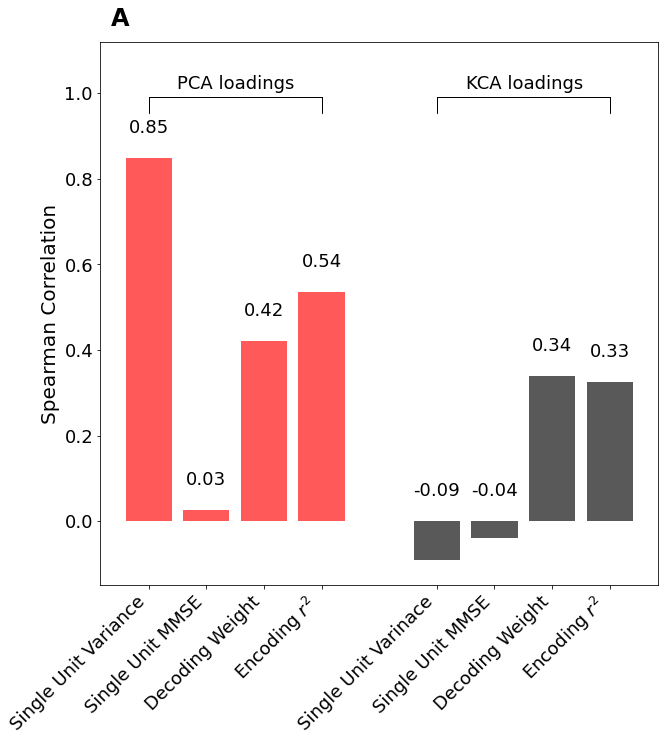

In [124]:
fig, ax = plt.subplots(figsize=(10, 10), )

bars = ax.bar([0, 1, 2, 3, 5, 6, 7, 8], [r[0, 0], r[3, 0], pca_decoding_weightsr2[3], pca_suencoding_r2[3],
                                         r[0, 1], r[3, 1], kca_decoding_weightsr2[3],
                                         kca_suencoding_r2[3]],
              color=['r', 'r', 'r', 'r', 'k','k', 'k', 'k'], alpha=0.65)

# Place numerical values above the bars
for rect in bars: 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=18)
    else:
        ax.text(rect.get_x() + rect.get_width()/2, 0.05, '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=18)
        
ax.set_ylim([-0.15, 1.12])
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8])
ax.set_xticklabels(['Single Unit Variance', 'Single Unit MMSE', 'Decoding Weight', 
                    'Encoding ' + r'$r^2$',
                    'Single Unit Varinace', 'Single Unit MMSE', 
                    'Decoding Weight', 'Encoding ' + r'$r^2$'],
                   rotation=45, fontsize=18, ha='right')
ax.tick_params(axis='y', labelsize=18)
ax.text(0.5, 1.0, 'PCA loadings', fontsize=18, ha='left', va='bottom')


ax.annotate("", xy=(0, 0.95), xytext=(3, 0.95), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax.text(5.5, 1.0, 'KCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(5, 0.95), xytext=(8, 0.95), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax.set_ylabel('Spearman Correlation', fontsize=20)
ax.text(0.02, 1.02, 'A', transform=ax.transAxes,
        fontsize=24, fontweight='bold', va='bottom')    

fig.savefig('sabes_loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)

### Peanut

In [126]:
fpath = '/media/akumar/Secondary/data/peanut/data_dict_peanut_day14.obj'

In [127]:
epochs = np.unique(peanut_kca_df['epoch'].values)

In [128]:
decoder_params = {'trainlag': 0, 'testlag': 0, 'decoding_window': 6}
fold_idx = 1

result = {}
for epoch in tqdm(epochs):
    
    result[epoch] = {}
    
    KCA_df = apply_df_filters(peanut_kca_df, epoch=epoch, fold_idx=fold_idx)
    pca_df = apply_df_filters(peanut_kca_df, epoch=epoch, fit_all=True, fold_idx=fold_idx)
    
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=KCA_df.iloc[0]['bin_width'], 
                      filter_fn='none')
    
    
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    kfold = KFold(n_splits=5, shuffle=False)
    next(kfold.split(X))
    train_idxs, test_idxs = next(kfold.split(X))
    ztrain = Z[train_idxs, :]
    ztest = Z[test_idxs, :]

    # Population level decoding/encoding - use the coefficient in the linear fit
    # Record both the weights in the coefficient but also the loadings onto the SVD

    xtrain = X[train_idxs, :]
    xtest = X[test_idxs, :]
    
    _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
    _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)


    result[epoch]['decoding_weights'] = decodingregressor.coef_
    result[epoch]['encoding_weights'] = encodingregressor.coef_
    
    u1, s1, vh1 = np.linalg.svd(decodingregressor.coef_[0:1, :], full_matrices=False)
    u4, s4, vh4 = np.linalg.svd(encodingregressor.coef_, full_matrices=False)
    
    result[epoch]['decoding_pos_svd'] = vh1
    result[epoch]['encoding_svd'] = u4
    
    r2_pos_decoding = []
    r2_encoding = []
    
    decoding_weights = []
    encoding_weights = []
    
    decoding_weights_svd = []
    encoding_weights_svd = []
    
    
    for neu_idx in range(X.shape[1]):           #Fit all neurons one by one
        
        xtrain = X[train_idxs, neu_idx][:, np.newaxis]
        xtest = X[test_idxs, neu_idx][:, np.newaxis]
        # Decoding
        r2_pos, _, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_pos_decoding.append(r2_pos)        
        decoding_weights.append(dr.coef_)
        
        # Encoding
        r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_encoding.append(r2_encoding_)
        encoding_weights.append(er.coef_)        
        
    result[epoch]['su_r2_pos_decoding'] = r2_pos_decoding
    result[epoch]['su_r2_encoding'] = r2_encoding
    result[epoch]['su_decoding_weight'] = decoding_weights
    result[epoch]['su_encoding_weight'] = encoding_weights        
    
    dim_vals = np.unique(KCA_df['dim'].values)
    kca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    pca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    
    for i, dim_ in enumerate(dim_vals):
        kca_df_ = KCA_df.loc[KCA_df['dim'] == dim_]
        kca_loadings[i, :] = calc_loadings(kca_df_.iloc[0]['KCA']['coef'])
        pca_loadings[i, :] = calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:dim_])
    
    result[epoch]['kca_loadings'] = kca_loadings
    result[epoch]['pca_loadings'] = pca_loadings

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.14s/it]


In [129]:
# For each quantity, calculate the spearman r2 
kca_decoding_weightsr2 = np.zeros(dim_vals.size)
kca_decoding_svdr2 = np.zeros(dim_vals.size)
pca_decoding_weightsr2 = np.zeros(dim_vals.size)
pca_decoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_kca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for epoch in epochs:
        y_kca.extend(result[epoch]['kca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[epoch]['decoding_weights'][0, :][np.newaxis, :].T, 6))
        x2.extend(calc_loadings(result[epoch]['decoding_pos_svd'].T, 6))

    kca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_kca)[0]
    kca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_kca)[0]
    
    pca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

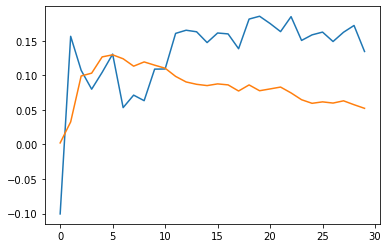

In [130]:
plt.plot(kca_decoding_weightsr2)
plt.plot(pca_decoding_weightsr2)

In [131]:
# For each quantity, calculate the spearman r2 
kca_suencoding_r2 = np.zeros(dim_vals.size)
pca_suencoding_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_kca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for epoch in epochs:
        y_kca.extend(result[epoch]['kca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[epoch]['su_r2_encoding'][idx])
                   for idx in range(len(result[epoch]['su_r2_encoding']))])

    kca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_kca)[0]
    pca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]

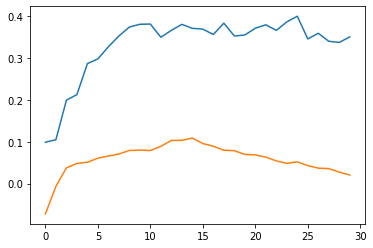

In [132]:
plt.plot(kca_suencoding_r2)
plt.plot(pca_suencoding_r2)

In [133]:
var_files = glob.glob('/media/akumar/Secondary/data/peanut_var2/peanut_var2_*.dat')
results_list = []
for var_file in var_files:
    result = {}
    with open(var_file, 'rb') as f:
        args = pickle.load(f)
        coefs = pickle.load(f)
        scores_and_supports = pickle.load(f)

    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in args[key].items():
                result[key_] = value_
        else:
            result[key] = value

    result['A'] = np.squeeze(coefs)
    results_list.append(result)
peanut_var_df = pd.DataFrame(results_list)

In [134]:
mmse = {}
variance = {}
for epoch in tqdm(epochs):
    # VAR is fit to fold idx 1 only
    df = apply_df_filters(peanut_var_df, epoch=epoch)
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=KCA_df.iloc[0]['bin_width'], 
                      filter_fn='none')

    x = np.squeeze(dat['spike_rates'])

    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    train_idxs, test_idxs = split_idxs[1]
    
    x = x[train_idxs]
    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    variance[epoch] = {}
    variance[epoch]['data'] = np.var(x, axis=0)
    W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))
    variance[epoch]['model'] = np.diag(W)
    
    # Do NOT Normalize
    #x = StandardScaler().fit_transform(np.squeeze(dat['spike_rates']))
    cross_cov_mats = calc_cross_cov_mats_from_data(x, T=6)
    mmse[epoch] = {}
    mmse[epoch]['dataT1'] = []
    mmse[epoch]['dataT3'] = []
    mmse[epoch]['dataT5'] = []
    mmse[epoch]['modelT1'] = []
    mmse[epoch]['modelT3'] = []
    mmse[epoch]['modelT5'] = []

    cross_cov_mats = torch.tensor(cross_cov_mats)
    for j in range(A.shape[0]):

        C = np.zeros((1, A.shape[0]))
        C[0, j] = 1

        
        mmse[epoch]['dataT5'].append(calc_mmse_from_cross_cov_mats(cross_cov_mats, 
                                                                   torch.tensor(C.T),
                                                                   project_mmse=False).detach().cpu().numpy())                
        mmse[epoch]['dataT3'].append(calc_mmse_from_cross_cov_mats(cross_cov_mats[0:4], 
                                                                   torch.tensor(C.T),
                                                                   project_mmse=False).detach().cpu().numpy())                
        mmse[epoch]['dataT1'].append(calc_mmse_from_cross_cov_mats(cross_cov_mats[0:2], 
                                                                   torch.tensor(C.T),
                                                                   project_mmse=False).detach().cpu().numpy())                
    
        c, cf, cfp = ssr.mmse_cov(5, proj=C)
        mmse[epoch]['modelT5'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.mmse_cov(3, proj=C)
        mmse[epoch]['modelT3'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

        c, cf, cfp = ssr.mmse_cov(1, proj=C)
        mmse[epoch]['modelT1'].append(np.trace(C @ c @ C.T - C @ cfp.T @ np.linalg.inv(cf) @ cfp @ C.T))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:30<00:00,  3.78s/it]


In [135]:
# (empirical su variance)
x1 = []
# (model su variance)
x2 =[]
# (emprirical T1)
x3 = []
# (emprirical T3)
x4 = []
# (emprirical T5)
x5 = []
# (model T1)
x6 = []
# (model T3)
x7 = []
# (model T5)
x8 = []

# pca loadings
y1 = []
# kca loadings 
y2 = []

fold_idx = 1
for epoch in tqdm(epochs):
    KCA_df = apply_df_filters(peanut_kca_df, epoch=epoch, fold_idx=fold_idx, dim=2)
    pca_df = apply_df_filters(peanut_kca_df, epoch=epoch, fit_all=True, fold_idx=fold_idx)
    
    x1.extend(variance[epoch]['data'])
    x2.extend(variance[epoch]['model'])

    x3.extend(mmse[epoch]['dataT1'])
    x4.extend(mmse[epoch]['dataT3'])
    x5.extend(mmse[epoch]['dataT5'])
    
    x6.extend(mmse[epoch]['modelT1'])
    x7.extend(mmse[epoch]['modelT3'])
    x8.extend(mmse[epoch]['modelT5'])
    
    y1.extend(calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    y2.extend(calc_loadings(KCA_df.iloc[0]['KCA']['coef'])) 

    
r = np.zeros((8, 2))
for i, x_ in enumerate([x1, x2, x3, x4, x5, x6, x7, x8]):
    for j, y_ in enumerate([y1, y2]):
        r[i, j] = scipy.stats.spearmanr(x_, y_)[0]    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 663.91it/s]


In [136]:
r[:, 0]

array([ 0.92157281,  0.76653942, -0.08316694, -0.12750543, -0.16904996,
        0.76652193,  0.77134888,  0.77130514])

In [137]:
r[:, 1]

array([ 0.06951138,  0.15636051, -0.04114497, -0.05708838, -0.05723949,
        0.15572143,  0.14974465,  0.14968426])

In [138]:
# Evaluate self consistency with model subspaces
reps = 10

spearmanr_kca = []

for i, epoch in tqdm(enumerate(epochs)):
    
    # Fold idx is 1 here
    df = apply_df_filters(peanut_var_df, epoch=epoch)
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=KCA_df.iloc[0]['bin_width'], 
                      filter_fn='none')
    x = np.squeeze(dat['spike_rates'])
    
    kfold = KFold(n_splits=5, shuffle=False)
    split_idxs = list(kfold.split(x))
    # Stick to the correct fold of the data
    train_idxs, test_idxs = split_idxs[1]
    
    x = x[train_idxs]

    
    A = df.iloc[0]['A']
    ssr = SSR(A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    eig, U = np.linalg.eig(ssr.P)
    eigorder = np.argsort(eig)
    U = U[:, eigorder]
        
    # Data derived
    
    kcamodel = KCA(d=2, T=1, causal_weights=(1, 0), project_mmse=False)
    kcamodel.estimate_data_statistics(x)

    empirical_loadings = np.zeros((reps, A.shape[0]))
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        empirical_loadings[j, :] = calc_loadings(coef_)
    
    # Model derived
    model_loadings = np.zeros((reps, A.shape[0]))
    kcamodel = KCA(d=2, T=1, causal_weights=(1, 0), project_mmse=False)
    kcamodel.cross_covs = ssr.autocorrelation(5)
    for j in range(reps):
        coef_, _ = kcamodel._fit_projection()
        model_loadings[j, :] = calc_loadings(coef_)
        
    sr = np.zeros((reps, reps))
    for j in range(reps):
        for k in range(reps):
            sr[j, k] = scipy.stats.spearmanr(empirical_loadings[j, :], model_loadings[k, :])[0]
    spearmanr_kca.append(sr)

8it [00:37,  4.69s/it]


In [139]:
[np.max(sr) for sr in spearmanr_kca]

[0.7432437583380977,
 0.6459815546772067,
 0.7642706131078225,
 0.6948879213030156,
 0.8073697790678922,
 0.3918722786647315,
 0.850991114149009,
 0.7453136011275546]

In [140]:
peanut_spearman_kca = [np.max(sr) for sr in spearmanr_kca]

In [141]:
loadingsW = []
loadingsPCA = []
for i, epoch in enumerate(epochs):

#     # OLS
#     df_ = apply_df_filters(dimreduc_df, dimreduc='OLS1', epoch=epoch, fold_idx=0)
#     A = np.squeeze(df_.iloc[0]['coef'])
#     W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))    
#     eig, U = np.linalg.eig(W)
#     eigorder = np.argsort(np.abs(eig))[::-1]
#     U = U[:, eigorder]
#     loadingsW.extend(calc_loadings(U[:, 0:2], 1))
    
    # SCAD
    df_ = apply_df_filters(peanut_var_df, epoch=epoch)
    W = scipy.linalg.solve_discrete_lyapunov(df_.iloc[0]['A'], np.eye(df_.iloc[0]['A'].shape[0]))
    eig, U = np.linalg.eig(W)
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
    loadingsW.extend(calc_loadings(U[:, 0:2], 1))

    # PCA
    df_ = apply_df_filters(peanut_kca_df, fit_all=True, epoch=epoch, fold_idx=1)
    V = df_.iloc[0]['PCA']['coef'][:, 0:2]
    loadingsPCA.extend(calc_loadings(V, 1))

In [142]:
peanut_spearmanr_pca = scipy.stats.spearmanr(loadingsW, loadingsPCA)[0]

In [143]:
peanut_spearmanr_pca

0.7850835548273537

In [87]:
# # Save
with open('peanut_su_correlations.dat', 'wb') as f:
    f.write(pickle.dumps(result))
    f.write(pickle.dumps(variance))
    f.write(pickle.dumps(mmse))
    # This is model self consistency
    f.write(pickle.dumps(spearmanr_kca))

In [223]:
# with open('peanut_su_correlations.dat', 'rb') as f:
#     result = pickle.load(f)
#     variance = pickle.load(f)
#     ammse = pickle.load(f)
#     spearmanr_kca = pickle.load(f)

In [144]:
peanut_bar_pca = [r[0, 0], r[4, 0], pca_decoding_weightsr2[3], pca_suencoding_r2[3]]
peanut_bar_kca = [r[0, 1], r[4, 1], kca_decoding_weightsr2[3], kca_suencoding_r2[3]]

### Plotting

In [157]:
with open('barplot_stats.dat', 'wb') as f:
    f.write(pickle.dumps(sabes_bar_pca))
    f.write(pickle.dumps(sabes_bar_kca))
    f.write(pickle.dumps(peanut_bar_pca))
    f.write(pickle.dumps(peanut_bar_kca))
    f.write(pickle.dumps([sabes_spearman_kca, sabes_spearmanr_pca, peanut_spearman_kca, peanut_spearmanr_pca]))

['r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k']

In [182]:
from matplotlib.patches import Rectangle

In [185]:
# Legend handler (from https://stackoverflow.com/questions/44310879/create-a-matplotlib-mpatches-with-a-rectangle-bi-colored-for-figure-legend)
class Handler(object):
    def __init__(self, color):
        self.color=color
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = plt.Rectangle([x0, y0], width/2, height, facecolor=self.color[0], alpha=self.color[1],
                                   edgecolor=self.color[0], transform=handlebox.get_transform())
        patch2 = plt.Rectangle([x0+width/2., y0], width/2., height, facecolor='k',alpha=self.color[1],
                                   edgecolor='k', transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        handlebox.add_artist(patch2)
        return patch


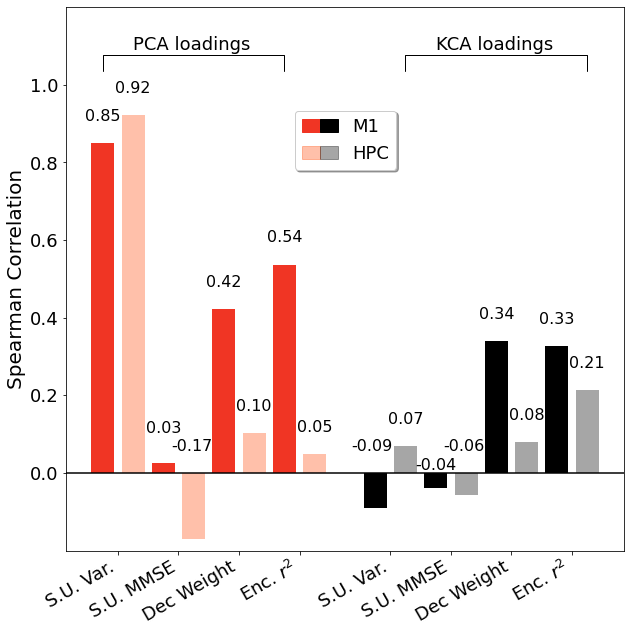

In [214]:
fig, ax = plt.subplots(figsize=(10, 10), )


x1 = np.array([0, 1, 2, 3, 4.5, 5.5, 6.5, 7.5])
x2 = x1 + 0.5

# Sabes
bar_sabes = ax.bar(x1,
              np.concatenate([sabes_bar_pca,sabes_bar_kca]),
              color=np.concatenate([4* ['#f03524'], 4*['k']]),
              alpha=1, width=0.38)
# Peanut
bar_peanut = ax.bar(x2,
              np.concatenate([peanut_bar_pca,peanut_bar_kca]),
              color=np.concatenate([4* ['#ff4d0d'], 4*['k']]),
              alpha=0.35, width=0.38, hatch='0')


# Place numerical values above the bars

# Manual adjustments of location to prevent conflicts
y_adjust = [0, 0.02, 0, 0, 0, -0.05, 0, 0]
x_adjust = [0, 0, 0, 0, -0.05, 0, 0, 0]
for i, rect in enumerate(bar_sabes): 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2 + x_adjust[i],
                rect.get_height() + 0.05 + y_adjust[i], '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=16)
    else:
        ax.text(rect.get_x() + rect.get_width()/2 + x_adjust[i],
                0.05 + y_adjust[i], '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=16)

y_adjust = [0, 0, 0, 0, 0, 0, 0, 0]
x_adjust = [0, -0.03, 0, 0, 0, -0.03, 0, 0]
for i,rect in enumerate(bar_peanut): 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2 + x_adjust[i],
                rect.get_height() + 0.05 + y_adjust[i], '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=16)
    else:
        ax.text(rect.get_x() + rect.get_width()/2 + x_adjust[i],
                0.05 + y_adjust[i], '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=16)

        
ax.set_ylim([-0.2, 1.2])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.25, 1.25, 2.25, 3.25, 4.75, 5.75, 6.75, 7.75])
ax.set_xticklabels(2 * ['S.U. Var.', 'S.U. MMSE',
                    'Dec Weight', 'Enc. ' + r'$r^2$'],
                   rotation=30, fontsize=18, ha='right')
ax.tick_params(axis='y', labelsize=18)
ax.text(0.5, 1.08, 'PCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(0, 1.03), xytext=(3, 1.03), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))


ax.text(5.5, 1.08, 'KCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(5, 1.03), xytext=(8, 1.03), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax.axhline(y=0, linestyle='-', color='k')
#### LEGEND #####
handles = [Rectangle((0, 0), 1, 1) for i in range(2)]
colors = [('#f03524', 1), ('#ff4d0d', 0.35)]
hmap = dict(zip(handles, [Handler(color) for color in colors]))
ax.legend(handles=handles, labels=['M1', 'HPC'], handler_map=hmap, loc=(0.41, 0.7), fontsize=18, shadow=True)

ax.set_ylabel('Spearman Correlation', fontsize=20)
fig.savefig('loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)
#fig.savefig('hwni/loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)

In [213]:
print([np.mean(sabes_spearman_kca), sabes_spearmanr_pca, np.mean(peanut_spearman_kca), peanut_spearmanr_pca])

[0.890524098975413, 0.8955476829317404, 0.7054913275544162, 0.7850835548273537]
